In [80]:
import numpy as np
import matplotlib.pyplot as plt

This notebook seeks to **NUMERICALLY** verify the results in Example 9.6.1.

# Varimax theory

$$
\Delta = \Lambda \bf{G}
$$
$(p \times k) \Lambda, (k \times k) G \text{ orthogonal matrix}$.

$\delta_{ij}$ represents the loadings of the ith variable on the jth factor.

Varimax maximizes the sum of the variances of the squared loadings within each column of the loading matrix, where each row is normalized by its communality:
$$
\phi = \sum_{j = 1}^k \sum_{i = 1}^p (d_{ij}^2 - \bar{d_j}) ^2
$$
where
$$
d_{ij} = \frac{\delta_{ij}}{h_i} \quad \text{and} \quad \bar{d_i} = \frac{1}{p} \sum_{i = 1}^p d_{ij}^2
$$

---

# $k = 2$

Step by step:

In [81]:
loadings = np.array([[0.628, 0.372],
                    [0.696,  0.313],
                    [0.899,  -0.05 ],
                    [0.779,  -0.201],
                    [0.728,  -0.2  ]])

p = loadings.shape[0]
k = loadings.shape[1]

h_i = np.sqrt(np.sum(loadings ** 2, axis=1))

theta = 40
theta_rad = np.deg2rad(theta)
G = np.array([[np.cos(theta_rad) , np.sin(theta_rad)],
              [-np.sin(theta_rad), np.cos(theta_rad)]])

delta = loadings @ G
d = delta / h_i[:,np.newaxis]
d_means = np.sum(d ** 2, axis=0) / p

In [82]:
phi = sum(sum((d[i,j] ** 2 - d_means[j]) ** 2 for i in range(p)) for j in range(k))

Generalize to function:

In [83]:
def calculate_phi(theta_degrees, loadings_matrix):
    p, k = loadings_matrix.shape
    h_i = np.sqrt(np.sum(loadings_matrix ** 2, axis=1))
    theta_rad = np.deg2rad(theta_degrees)
    G = np.array([[np.cos(theta_rad) , np.sin(theta_rad)],
                [-np.sin(theta_rad), np.cos(theta_rad)]])

    delta = loadings @ G
    d = delta / h_i[:,np.newaxis]
    d_means = np.sum(d ** 2, axis=0) / p
    phi = sum(sum((d[i,j] ** 2 - d_means[j]) ** 2 for i in range(p)) for j in range(k))
    return phi

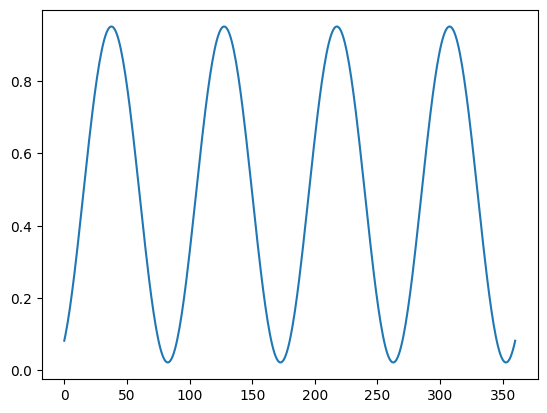

In [84]:
# Unrotated loadings from open/closed book
loadings = np.array([[0.628, 0.372],
                    [0.696,  0.313],
                    [0.899,  -0.05 ],
                    [0.779,  -0.201],
                    [0.728,  -0.2  ]])

phi_calc = [calculate_phi(theta_degrees=theta, loadings_matrix=loadings) for theta in np.linspace(0, 360, 400)]

plt.plot(np.linspace(0, 360, 400), phi_calc)

Let's zoom in on one of the peaks.

Optimal degrees:  37.62976297629763


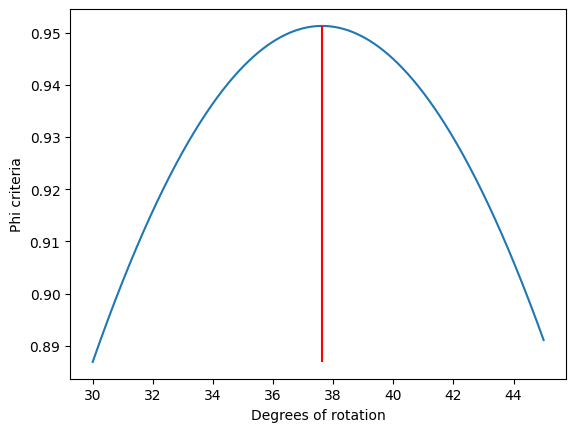

In [85]:
loadings = np.array([[0.628, 0.372],
                    [0.696,  0.313],
                    [0.899,  -0.05 ],
                    [0.779,  -0.201],
                    [0.728,  -0.2  ]])


degrees = np.linspace(30, 45, 10**4)
phi_calc = [calculate_phi(theta_degrees=theta, loadings_matrix=loadings) for theta in degrees]

plt.plot(degrees, phi_calc)
plt.vlines(degrees[np.argmax(phi_calc)],min(phi_calc), max(phi_calc),color="red")
plt.xlabel("Degrees of rotation")
plt.ylabel("Phi criteria")
print("Optimal degrees: ", degrees[np.argmax(phi_calc)])

Optimum is reached at 37.6, maching the book.

Let's do the optimization with a function:

In [86]:
def calculate_phi(theta_degrees, loadings_matrix):
    """
    WARNING: Give theta_degrees as a 1D array.
    theta_degrees = [36.7]
    """
    p, k = loadings_matrix.shape
    h_i = np.sqrt(np.sum(loadings_matrix ** 2, axis=1))
    theta_degrees = float(theta_degrees) # From 1D array to float -> Means floats as theta_degrees actually works anyway.
    theta_rad = np.deg2rad(theta_degrees)
    G = np.array([[np.cos(theta_rad) , np.sin(theta_rad)],
                [-np.sin(theta_rad), np.cos(theta_rad)]])

    delta = loadings_matrix @ G
    d = delta / h_i[:,np.newaxis]
    d_means = np.sum(d ** 2, axis=0) / p
    phi = sum(sum((d[i,j] ** 2 - d_means[j]) ** 2 for i in range(p)) for j in range(k))
    return phi

In [87]:
from scipy.optimize import minimize
loadings = np.array([[0.628, 0.372],
                    [0.696,  0.313],
                    [0.899,  -0.05 ],
                    [0.779,  -0.201],
                    [0.728,  -0.2  ]])

print(calculate_phi(theta_degrees=37.6, loadings_matrix=loadings))

minimize(lambda x: -calculate_phi(theta_degrees=x, loadings_matrix=loadings), x0=[37.6], bounds=[(0, 90)])

0.9512816110276954


  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -0.9512826007128095
        x: [ 3.763e+01]
      nit: 3
      jac: [ 3.331e-08]
     nfev: 8
     njev: 4
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

___

# Varimax for $k > 2$

Let's extend the method in the case of $k > 2$ factors:

*In the case of k > 2 factors, an iterative solution for the rotation is used. The first and second factors are rotated by an angle determined by the above method. The new first factor is then rotated with the original third factor, and so on, until all the $\frac{1}{2}k(k -1)$ pairs of factors have been rotated . This sequence of rotations is called a cycle. These cycles are then repeated until one is completed in which all the angles have achieved some predetermined convergence criterion.* (p. 270)

In [88]:
# Correlation matrix for the applicant data in the book
corr_matrix = np.zeros((15, 15))

correlation_data = np.array([[1.00, 0.24, 0.04, 0.31, 0.09, 0.23, -0.11, 0.27, 0.55, 0.35, 0.28, 0.34, 0.37, 0.47, 0.59],
            [1.00, 0.12, 0.38, 0.43, 0.37, 0.35, 0.48, 0.14, 0.34, 0.55, 0.51, 0.51, 0.28, 0.38],
            [1.00, 0.00, 0.00, 0.08, -0.03, 0.05, 0.27, 0.09, 0.04, 0.20, 0.29, -0.32, 0.14],
            [1.00, 0.3, 0.48, 0.65, 0.35, 0.14, 0.39, 0.35, 0.5, 0.61, 0.69, 0.33],
            [1.00, 0.81, 0.41, 0.82, 0.02, 0.70, 0.84, 0.72, 0.67, 0.48, 0.25],
            [1.00, 0.36, 0.83, 0.15, 0.70, 0.76, 0.88, 0.78, 0.53, 0.42],
            [1.00, 0.23, -0.16, 0.28, 0.21, 0.39, 0.42, 0.45, 0.00],
            [1.00, 0.23, 0.81, 0.86, 0.77, 0.73, 0.55, 0.55],
            [1.00, 0.34, 0.20, 0.30, 0.35, 0.21, 0.69],
            [1.00, 0.78, 0.71, 0.79, 0.61, 0.62],
            [1.00, 0.78, 0.77, 0.55, 0.43],
            [1.00, 0.88, 0.55, 0.53],
            [1.00, 0.54, 0.57],
            [1.00, 0.40],
            [1]], dtype = "object")

for i in range(15):
    corr_matrix[i, i:] = correlation_data[i]

lower_indices = np.tril_indices(15, -1)
corr_matrix[lower_indices] = corr_matrix.T[lower_indices]

corr_matrix.shape

(15, 15)

In [89]:
# REMEMBER TO CHANGE K IN CELLS BELOW, IF YOU USE THIS
# Open/Closed data | corr_matrix
# corr_matrix = np.array([[1.   , 0.553, 0.547, 0.410, 0.389],
#                         [0.553, 1.   , 0.61 , 0.485, 0.437],
#                         [0.547, 0.61 , 1.   , 0.711, 0.665],
#                         [0.410, 0.485, 0.711, 1.   , 0.607],
#                         [0.389, 0.437, 0.665, 0.607, 1.   ]])

The following functions from utils, have been modified to take summarization (corr / cov) matrix instead of data matrix:

In [90]:
def calculate_objective(specific_variance, summarize_matrix, k):
    """
    Calculate the factor model maximum likelihood objective function.

    Parameters
    ---
    specific_variance : (p,) arraylike
        The specific variances for each variable
    
    summarize_matrix : (p, p) arraylike
        The matrix used to summarize the data. Either covariance or correlation matrix.

    k: float
        Number of factors

    standardized :       boolean
        Whether to use correlation matrix (standardized variables) or the covariance matrix
        in calculations.

    Returns
    ---
    Objective function value: float
    """
    p = summarize_matrix.shape[1]

    # Step 1
    S = summarize_matrix
    Psi = np.diag(specific_variance)
    Psi_sq_inv = np.linalg.inv(Psi ** 0.5)
    S_star = Psi_sq_inv @ S @ Psi_sq_inv

    # Step 2
    eigval, eigvec = np.linalg.eig(S_star)

    # Step 3
    lambda_star = []
    for i in range(k):
        lambda_star.append(max(eigval[i] - 1, 0) ** 0.5 * eigvec[:,i])
    lambda_star = np.array(lambda_star).T

    # Step 4
    lambda_hat = Psi ** 0.5 @ lambda_star

    # Step 5
    internal = np.linalg.inv(lambda_hat @ lambda_hat.T + Psi) @ S
    result = np.trace(internal) - np.log(np.linalg.det(internal)) - p

    return result

def factor_model_solution(summarize_matrix, k, x0_guess=None, ):
    """
    Optimize the factor model w.r.t. psi, and calculate psi hat and lambda hat.

    Parameters
    ---
    X: (n, p) arraylike
        data matrix

    k: integer
        Number of factors

    x0_guess : (p,) arraylike
        The initial guess for the minimization function

    Returns
    ---
    tuple : (psi_hat, lambda_hat) 
        where
        psi_hat: (p,p) diagonal matrix. 
        lambda_hat: (p, k) factor loadings matrix
    
    """
    if x0_guess is None:
        x0_guess = np.ones(summarize_matrix.shape[0])

    # Optimize
    problem = minimize(fun=lambda x: calculate_objective(np.exp(x), summarize_matrix=summarize_matrix, k=k),
                       x0=x0_guess)
    
    psi_hat = np.diag(np.exp(problem.x))

    # Calculate lambda hat
    S = summarize_matrix
    Psi_sq_inv = np.linalg.inv(psi_hat ** 0.5)
    S_star = Psi_sq_inv @ S @ Psi_sq_inv
    eigval, eigvec = np.linalg.eig(S_star)
    lambda_star = []
    for i in range(k):
        lambda_star.append(max(eigval[i] - 1, 0) ** 0.5 * eigvec[:,i])
    lambda_star = np.array(lambda_star).T
    lambda_hat = psi_hat ** 0.5 @ lambda_star

    return (psi_hat, lambda_hat, problem.success)

In [91]:
np.set_printoptions(linewidth=200)
_, lambda_hat, success = factor_model_solution(corr_matrix, 
                                               k=7,
                                               x0_guess=np.ones(corr_matrix.shape[0])
                                               )
print("Success :", success)
np.round(lambda_hat, 3)

Success : True


array([[ 0.291, -0.268,  0.442,  0.379,  0.044,  0.209, -0.141],
       [ 0.393, -0.059, -0.183,  0.307,  0.312, -0.2  , -0.519],
       [-0.007,  0.408, -0.17 ,  0.265,  0.33 ,  0.289,  0.04 ],
       [ 0.595, -0.462, -0.243,  0.132,  0.03 ,  0.331, -0.149],
       [ 0.809,  0.093, -0.093, -0.085,  0.25 , -0.381,  0.025],
       [ 0.977,  0.215,  0.006, -0.   , -0.   ,  0.   , -0.   ],
       [ 0.461, -0.397, -0.794,  0.   , -0.   , -0.   ,  0.   ],
       [ 0.831,  0.079,  0.153,  0.173,  0.191, -0.316,  0.022],
       [ 0.163, -0.054,  0.323,  0.619,  0.069,  0.168,  0.012],
       [ 0.739, -0.105,  0.129,  0.303,  0.326, -0.183,  0.326],
       [ 0.772,  0.025,  0.171,  0.059,  0.46 , -0.31 , -0.11 ],
       [ 0.883,  0.085, -0.021,  0.185,  0.223,  0.088, -0.104],
       [ 0.798,  0.003, -0.067,  0.292,  0.461,  0.198,  0.018],
       [ 0.694, -0.696,  0.184, -0.   , -0.   ,  0.   , -0.   ],
       [ 0.441, -0.059,  0.286,  0.847, -0.02 , -0.005, -0.001]])

In [92]:
def phi_criterion(loadings):
    """
    calculate phi, without rotation.
    """
    p, k = loadings.shape
    h_i = np.sqrt(np.sum(loadings ** 2, axis=1))
    d = loadings / h_i[:,np.newaxis]
    d_means = np.sum(d ** 2, axis=0) / p
    phi = sum(sum((d[i,j] ** 2 - d_means[j]) ** 2 for i in range(p)) for j in range(k))
    return phi

In [ ]:
rotation_lambda = lambda_hat.copy()
k = rotation_lambda.shape[1]
pairs = [(i,j) for i in range(k - 1) for j in range(k) if j > i]

phi_iterations = []
# Begin a cycle
for _ in range(30):
    for i,j in pairs:
        # Pick out columns i,j and convert to k = 2 subproblem
        two_loadings_columns = np.array([rotation_lambda[:,i], rotation_lambda[:, j]]).T

        # Find optimal theta
        problem = minimize(lambda x: -calculate_phi(theta_degrees=x, loadings_matrix=two_loadings_columns), x0=[45], bounds=[(0, 360)])
        if not problem.success:
            raise Exception("Warning: Optimization algorithm didn't find optimal solution")

        theta = problem.x[0] # Solution is given in a (1,) array


        # Rotate columns
        theta_rad = np.deg2rad(theta)
        G = np.array([[np.cos(theta_rad) , np.sin(theta_rad)],
                    [-np.sin(theta_rad), np.cos(theta_rad)]])
        
        rotated_two_loadings = two_loadings_columns @ G

        # Replace old columns
        rotation_lambda[:,i] = rotated_two_loadings[:,0]
        rotation_lambda[:,j] = rotated_two_loadings[:,1]

        # Repeat
    phi_iterations.append(phi_criterion(rotation_lambda))

Text(0.5, 1.0, 'The objective function for each iteration')

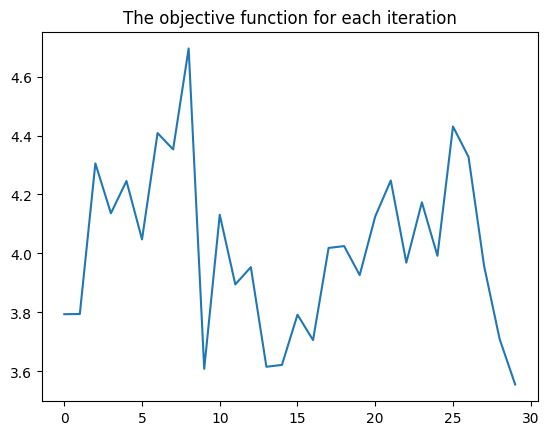

In [96]:
plt.plot(phi_iterations)
plt.title("The objective function for each iteration")

The algorithm should converge as each rotation increases the objective function, and phi is bounded from above. This is however **not** what happens.